In [1]:

from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset
from transformers import (ElectraForSequenceClassification,
                          ElectraTokenizerFast, EvalPrediction, InputFeatures,
                          Trainer, TrainingArguments, glue_compute_metrics, pipeline)

transformers.__version__

'4.45.1'

In [2]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from shutil import copyfile
copyfile(src = "/kaggle/input/balancing-script/Class Balancing.py", dst = "../working/Class_Balancing.py")
from Class_Balancing import create_datasets

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu = torch.device('cpu')

In [5]:
class TrainerDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, evidences=None):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.evidences=evidences

        # Tokenize the input
        self.tokenized_inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")   

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return InputFeatures(
            input_ids=self.tokenized_inputs['input_ids'][idx],
#             token_type_ids=self.tokenized_inputs['token_type_ids'][idx],
            attention_mask=self.tokenized_inputs['attention_mask'][idx],
            label=self.targets[idx])   

In [6]:
# Set seed for reproducibility
np.random.seed(123)


from typing import Dict
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score
from transformers import EvalPrediction
from transformers.data.metrics import glue_compute_metrics

def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=1)
    
    # Compute GLUE task metrics
    task_metrics = glue_compute_metrics(
        task_name="sst-2",
        preds=preds,
        labels=p.label_ids
    )
    
    # Compute additional metrics
    f1 = f1_score(p.label_ids, preds, average="binary")  # Binary classification
    precision = precision_score(p.label_ids, preds, average="binary")
    recall = recall_score(p.label_ids, preds, average="binary")
    mcc = matthews_corrcoef(p.label_ids, preds)
    
    # Compute AUC
    # For AUC, we need the raw predictions (probabilities). Assuming predictions are logits:
    if len(p.predictions.shape) > 1:  # Check if predictions are logits
        probs = np.exp(p.predictions) / np.exp(p.predictions).sum(axis=1, keepdims=True)
        auc = roc_auc_score(p.label_ids, probs[:, 1])  # Assuming binary classification
    else:
        auc = None  # AUC cannot be calculated without probabilities
    
    # Add custom metrics to the output dictionary
    task_metrics.update({
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "mcc": mcc,
        "auc": auc,
    })
    
    return task_metrics

from torch import nn


class CustomTrainer(Trainer):
    
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        # move weights to correct device
        device = logits.device
        weight = torch.tensor(self.class_weights, device=device)
        
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


In [7]:
training_args = TrainingArguments(
    output_dir= "test",
    num_train_epochs=2, 
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,    
    dataloader_drop_last=True,  # Make sure all batches are of equal size
)

model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2, ignore_mismatched_sizes=True)
model.to(device)
models = {}
import pickle
task = "eraser_movie"
with open(f"/kaggle/input/balanced-datasets/{task}_train.obj", 'rb') as pickle_file:
    train_dataset = pickle.load(pickle_file)
with open(f"/kaggle/input/balanced-datasets/{task}_eval.obj", 'rb') as pickle_file:
        eval_dataset = pickle.load(pickle_file)
k, v = np.unique(train_dataset.targets, return_counts=True)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    class_weights = list((v/np.sum(v)).astype(np.float32)))
trainer.train()
model_result = trainer.evaluate()
print("Accuracy: {}".format(model_result["eval_acc"]))
models[f"{task}_original"] = model


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Accuracy: 0.8020833333333334


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [8]:
model_result

{'eval_loss': 0.40476512908935547,
 'eval_acc': 0.8020833333333334,
 'eval_f1': 0.7790697674418605,
 'eval_precision': 0.8375,
 'eval_recall': 0.7282608695652174,
 'eval_mcc': 0.6062203440912076,
 'eval_auc': 0.9098913043478261,
 'eval_runtime': 2.0215,
 'eval_samples_per_second': 98.936,
 'eval_steps_per_second': 6.431,
 'epoch': 2.0}

In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def train_model(train_dataset, eval_dataset, output_dir):
    
    training_args = TrainingArguments(
        output_dir= output_dir,
        num_train_epochs=2, 
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=16,    
        dataloader_drop_last=True,  # Make sure all batches are of equal size
    )
    
    model_5 = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2, ignore_mismatched_sizes=True)
    model_5.to(device)
    
    k, v = np.unique(train_dataset.targets, return_counts=True)
    trainer_5 = CustomTrainer(
        model=model_5,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        class_weights = list((v/np.sum(v)).astype(np.float32)))
    trainer_5.train()
    model_result = trainer_5.evaluate()
    print("Accuracy: {}".format(model_result["eval_acc"]))
    return model_5, model_result

import gc




In [10]:
# task = "eraser_movie"
# with open(f"/kaggle/input/balanced-datasets/{task}_test.obj", 'rb') as pickle_file:
#         test_dataset = pickle.load(pickle_file)
# model.to(device_cpu)
# model(test_dataset.tokenized_inputs.input_ids.to(device_cpu))

In [11]:
import pickle
skip = 0
test_data = {}
for task in ["eraser_movie"]:
    
    with open(f"/kaggle/input/balanced-datasets/{task}_eval.obj", 'rb') as pickle_file:
        eval_dataset = pickle.load(pickle_file)
        
    with open(f"/kaggle/input/balanced-datasets/{task}_test.obj", 'rb') as pickle_file:
        test_dataset = pickle.load(pickle_file)
        test_data[task] = test_dataset
        

    
    for file in os.listdir(f"/kaggle/input/paraphrase-dataset/")[skip:]:
        print(file)
        with open("/kaggle/input/paraphrase-dataset/"+file, 'rb') as pickle_file:
            _, pred = train_model(pickle.load(pickle_file), eval_dataset, f"models/{task}/")
            
            models[file.split(".obj")[0]] = pred
            gc.collect()



/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


eraser_movie_50_paraphrase_70_3.obj


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7447916666666666
eraser_movie_50_paraphrase_100_4.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7239583333333334
eraser_movie_50_paraphrase_70_1.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.6979166666666666
eraser_movie_50_paraphrase_50_0.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.6822916666666666
eraser_movie_50_paraphrase_5_1.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.640625
eraser_movie_50_paraphrase_20_4.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.8020833333333334
eraser_movie_50_paraphrase_50_2.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.78125
eraser_movie_50_paraphrase_70_0.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7760416666666666
eraser_movie_50_paraphrase_70_4.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7395833333333334
eraser_movie_50_paraphrase_70_2.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7708333333333334
eraser_movie_50_paraphrase_10_3.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7916666666666666
eraser_movie_50_paraphrase_50_4.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7395833333333334
eraser_movie_50_paraphrase_5_0.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.796875
eraser_movie_50_paraphrase_10_2.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.8072916666666666
eraser_movie_50_paraphrase_5_2.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.78125
eraser_movie_50_paraphrase_10_1.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.796875
eraser_movie_50_paraphrase_20_1.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7447916666666666
eraser_movie_50_paraphrase_100_0.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7760416666666666
eraser_movie_50_paraphrase_20_3.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7708333333333334
eraser_movie_50_paraphrase_20_2.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.734375
eraser_movie_50_paraphrase_5_3.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7916666666666666
eraser_movie_50_paraphrase_5_4.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.8020833333333334
eraser_movie_50_paraphrase_100_2.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.6822916666666666
eraser_movie_50_paraphrase_100_3.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7708333333333334
eraser_movie_50_paraphrase_20_0.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.6822916666666666
eraser_movie_50_paraphrase_50_3.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.6770833333333334
eraser_movie_50_paraphrase_10_4.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.796875
eraser_movie_50_paraphrase_100_1.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.703125
eraser_movie_50_paraphrase_50_1.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.7708333333333334
eraser_movie_50_paraphrase_10_0.obj


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Some weights of DistilBertForSeq

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.703125


In [12]:

os.mkdir("/kaggle/working/fitted_models")
len(list(models.items()))

31

In [13]:
df = pd.DataFrame(list(models.items())[1:])
res = pd.DataFrame(list(df[1]))
name = pd.DataFrame(list(df[0].map(lambda x:x.split("_")[-2:])))
name.columns = ["Paraphrase %", "Model ID"]
df = pd.concat([df[0],name.astype(int), res], axis=1)
df = df.sort_values(["Paraphrase %", "Model ID"])
df.to_csv(fr"metrics_{skip}.csv")
df

,0,Paraphrase %,Model ID,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_auc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
12,eraser_movie_50_paraphrase_5_0,5,0,0.435871,0.796875,0.760736,0.873239,0.673913,0.604255,0.914674,2.1463,93.184,6.057,2.0
4,eraser_movie_50_paraphrase_5_1,5,1,0.636618,0.640625,0.439024,0.870968,0.293478,0.344145,0.771087,2.1196,94.357,6.133,2.0
14,eraser_movie_50_paraphrase_5_2,5,2,0.503828,0.781250,0.716216,0.946429,0.576087,0.600195,0.909783,2.1338,93.728,6.092,2.0
20,eraser_movie_50_paraphrase_5_3,5,3,0.469641,0.791667,0.753086,0.871429,0.663043,0.594775,0.887935,2.1374,93.571,6.082,2.0
21,eraser_movie_50_paraphrase_5_4,5,4,0.418387,0.802083,0.779070,0.837500,0.728261,0.606220,0.900000,2.1333,93.752,6.094,2.0
29,eraser_movie_50_paraphrase_10_0,10,0,0.552858,0.703125,0.622517,0.796610,0.510870,0.423228,0.821739,2.1145,94.585,6.148,2.0
15,eraser_movie_50_paraphrase_10_1,10,1,0.419564,0.796875,0.774566,0.827160,0.728261,0.595059,0.900978,2.1265,94.051,6.113,2.0
13,eraser_movie_50_paraphrase_10_2,10,2,0.395975,0.807292,0.793296,0.816092,0.771739,0.613912,0.908913,2.1286,93.960,6.107,2.0
10,eraser_movie_50_paraphrase_10_3,10,3,0.472884,0.791667,0.740260,0.919355,0.619565,0.608513,0.892283,2.1161,94.514,6.143,2.0
26,eraser_movie_50_paraphrase_10_4,10,4,0.454925,0.796875,0.757764,0.884058,0.663043,0.607041,0.900217,2.1424,93.352,6.068,2.0


In [14]:
from scipy.stats import gaussian_kde
from sklearn.metrics import auc
def cut_off_kde(X, lower_limit=None, upper_limit=None):
    
    """ Function used to generate points of bounded KDE plot

    Args:
        X (array): Data point
        lower_limit (float, optional): lower bound of KDE plot. Defaults to None.
        upper_limit (float, optional): upper bound of KDE plot. Defaults to None.

    Returns:
        (list, list): (list of x coordinates,  list of y coordinates)
    """
    
    # Setting plot limits if they were not provided and don't use limits if they are significantly smaller than smallest observation
    if lower_limit == None:
        lower_limit = np.min(X) - np.std(X)
    else:
        lower_limit = np.max([ np.min(X) - np.std(X), lower_limit])
        
    if upper_limit == None:
        upper_limit = np.max(X) + np.std(X)
    else:
        upper_limit = np.min([np.max(X) + np.std(X), upper_limit])
    x2 = np.linspace(lower_limit, upper_limit, 1001)
    
    # Fitting gaussian KDE  
    if np.min(X)==np.max(X):
        return [], []
    else:
        kde_full = gaussian_kde(X)
        y2 = kde_full(x2)
    
    # Scaling resulting distribution
    area_within_bounds = auc(x2, y2)
    y2 /= area_within_bounds
    return x2, y2

def plot_kde_bounded(X, lower_limit=None, upper_limit=None, label = None):
    """ Function used to plot bounded KDE

    Args:
        X (array): Data point
        lower_limit (float, optional): lower bound of KDE plot. Defaults to None.
        upper_limit (float, optional): upper bound of KDE plot. Defaults to None.
        label: plot label
    Returns:
        None
    """
    x, y = cut_off_kde(X, lower_limit, upper_limit)
    if len(x)==0:
        return
    line = plt.plot(x, y, label=label)
    color = line[0].get_color()
    plt.vlines(x[-1], 0, y[-1], color=color)
    plt.vlines(x[0], 0, y[0], color=color)


In [15]:
df.columns = [str(col).replace("eval_", "") for col in df.columns]

In [16]:
df.to_csv("2_epoch_synonym_percentage.csv")
df_3 = df
df_1 = df
df_2 = df
df

,0,Paraphrase %,Model ID,loss,acc,f1,precision,recall,mcc,auc,runtime,samples_per_second,steps_per_second,epoch
12,eraser_movie_50_paraphrase_5_0,5,0,0.435871,0.796875,0.760736,0.873239,0.673913,0.604255,0.914674,2.1463,93.184,6.057,2.0
4,eraser_movie_50_paraphrase_5_1,5,1,0.636618,0.640625,0.439024,0.870968,0.293478,0.344145,0.771087,2.1196,94.357,6.133,2.0
14,eraser_movie_50_paraphrase_5_2,5,2,0.503828,0.781250,0.716216,0.946429,0.576087,0.600195,0.909783,2.1338,93.728,6.092,2.0
20,eraser_movie_50_paraphrase_5_3,5,3,0.469641,0.791667,0.753086,0.871429,0.663043,0.594775,0.887935,2.1374,93.571,6.082,2.0
21,eraser_movie_50_paraphrase_5_4,5,4,0.418387,0.802083,0.779070,0.837500,0.728261,0.606220,0.900000,2.1333,93.752,6.094,2.0
29,eraser_movie_50_paraphrase_10_0,10,0,0.552858,0.703125,0.622517,0.796610,0.510870,0.423228,0.821739,2.1145,94.585,6.148,2.0
15,eraser_movie_50_paraphrase_10_1,10,1,0.419564,0.796875,0.774566,0.827160,0.728261,0.595059,0.900978,2.1265,94.051,6.113,2.0
13,eraser_movie_50_paraphrase_10_2,10,2,0.395975,0.807292,0.793296,0.816092,0.771739,0.613912,0.908913,2.1286,93.960,6.107,2.0
10,eraser_movie_50_paraphrase_10_3,10,3,0.472884,0.791667,0.740260,0.919355,0.619565,0.608513,0.892283,2.1161,94.514,6.143,2.0
26,eraser_movie_50_paraphrase_10_4,10,4,0.454925,0.796875,0.757764,0.884058,0.663043,0.607041,0.900217,2.1424,93.352,6.068,2.0


In [17]:
import seaborn as sns



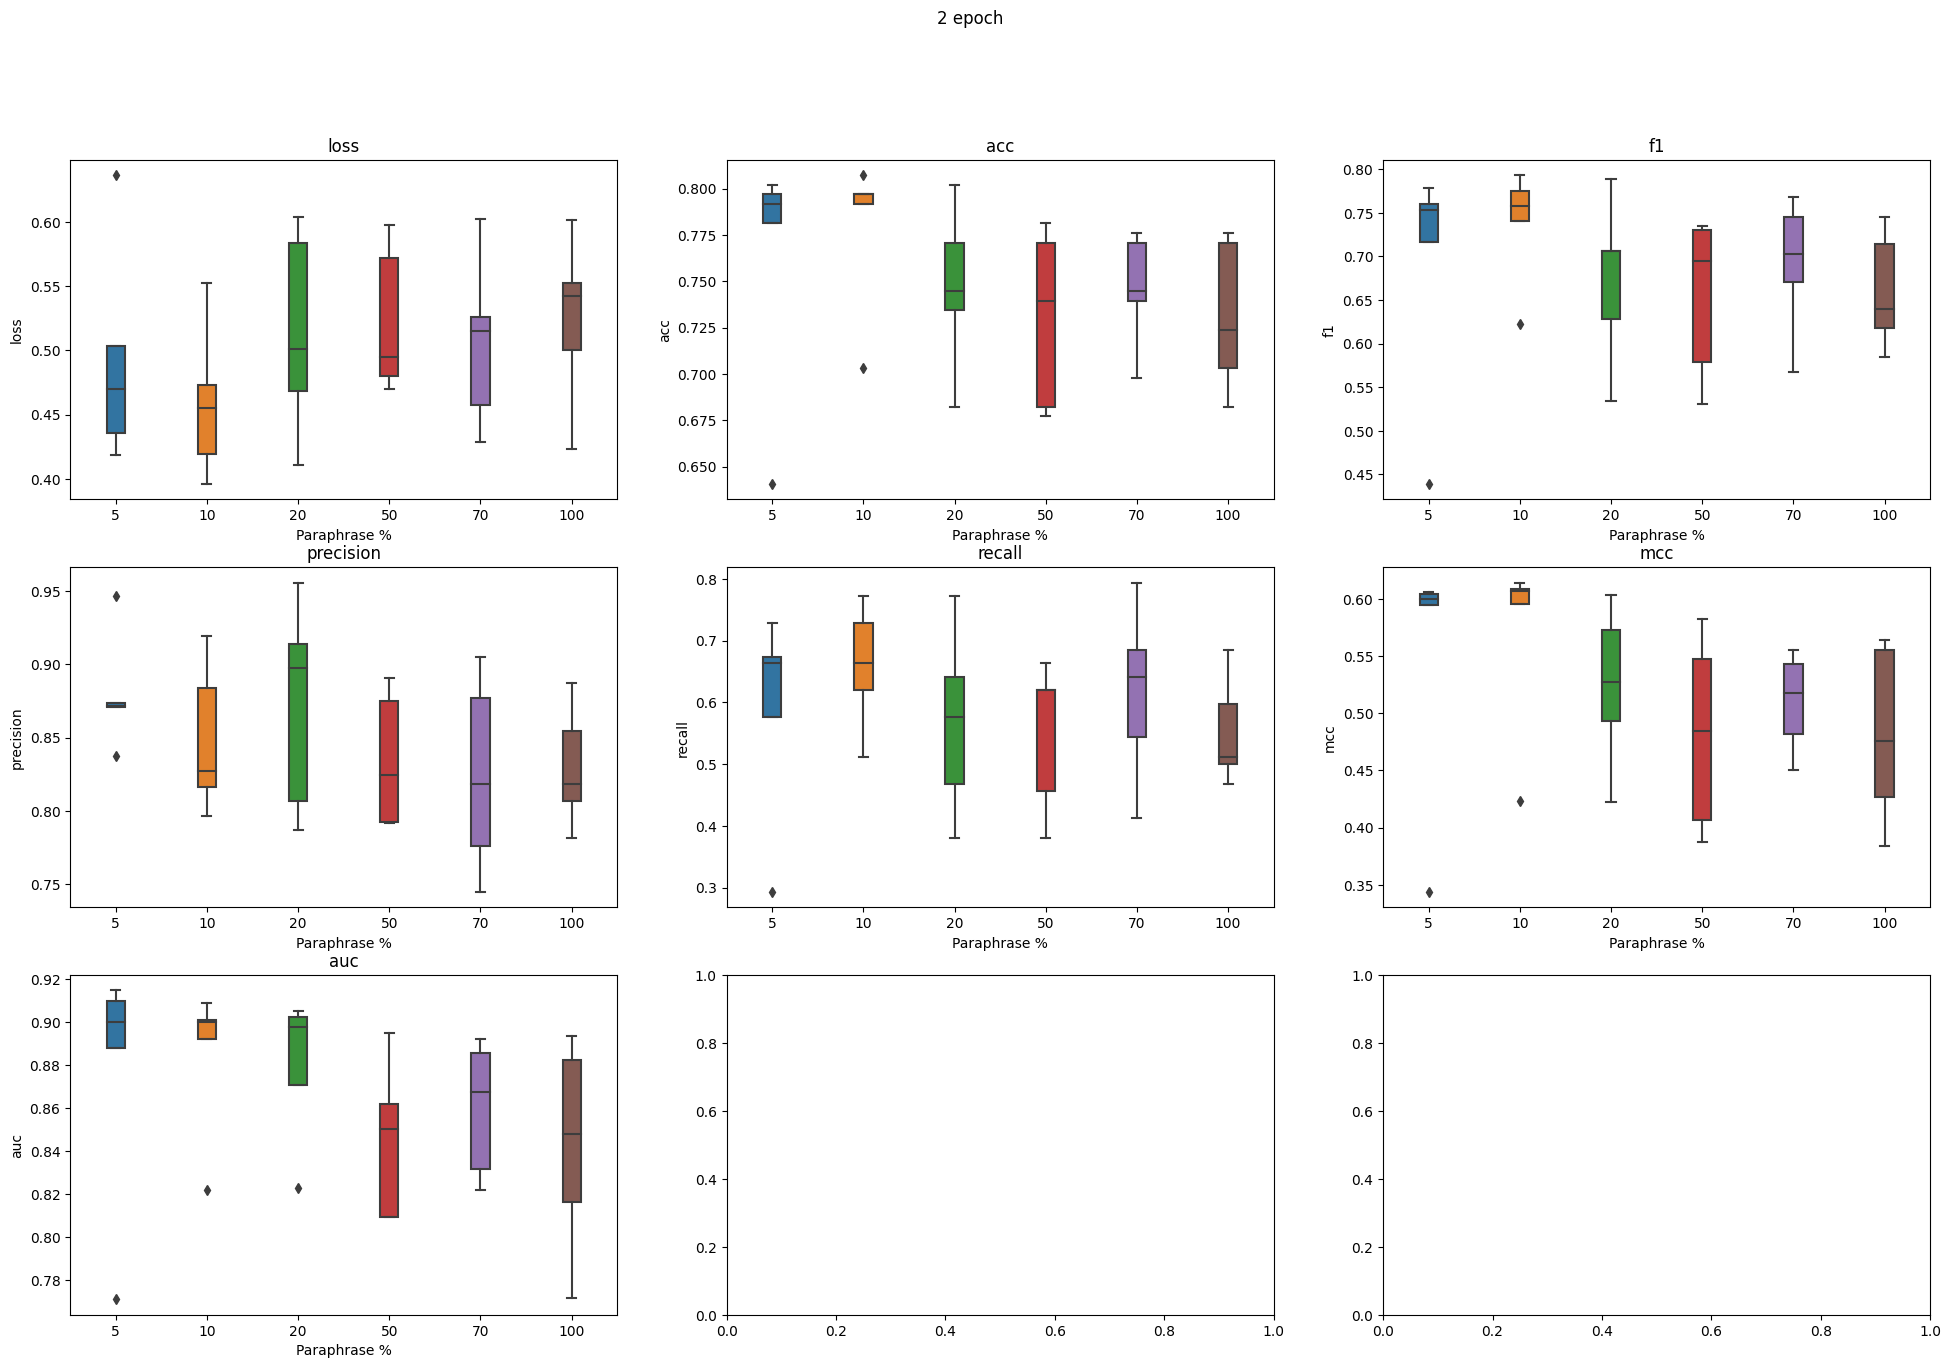

In [18]:
fig, ax = plt.subplots(int(np.ceil((len(df.columns)-7)/3)), 3, figsize=(24,5 * int(np.ceil((len(df.columns)-7)/3))))
i = 0
for measure in df.columns[3:-4]:
    sns.boxplot(x='Paraphrase %', y=measure,width = 0.2, data=df, ax = ax[i//3, i%3])
    ax[i//3, i%3].set_title(measure)
    i += 1
fig.suptitle(f'{int(df["epoch"][0])} epoch')
plt.show()

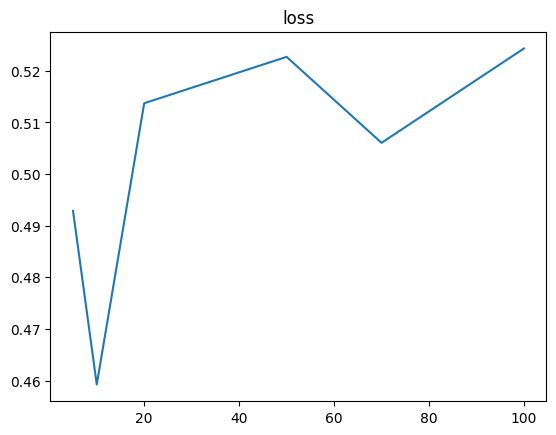

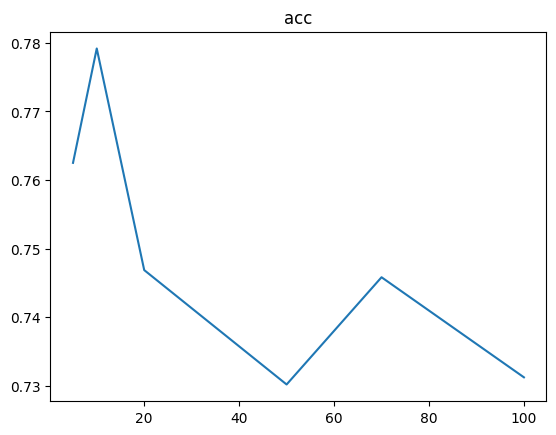

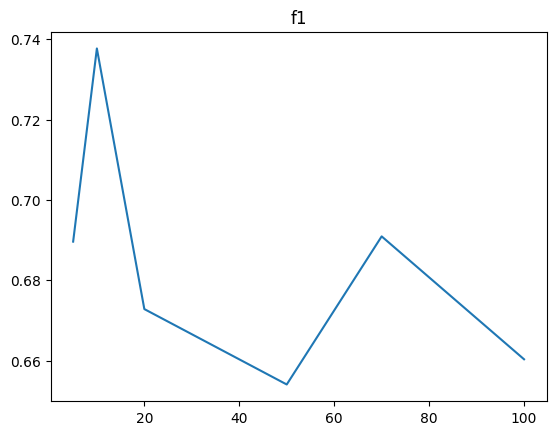

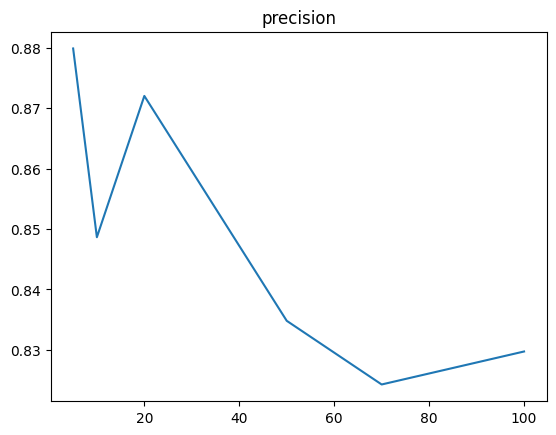

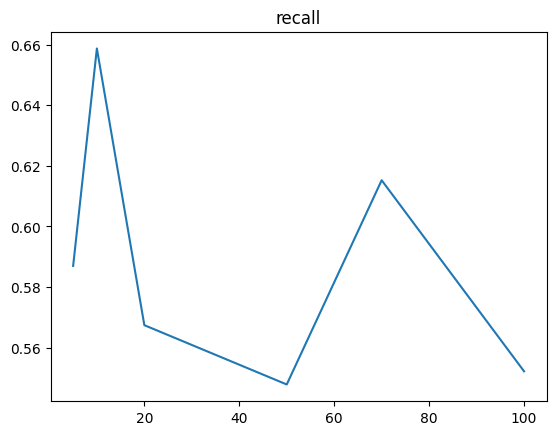

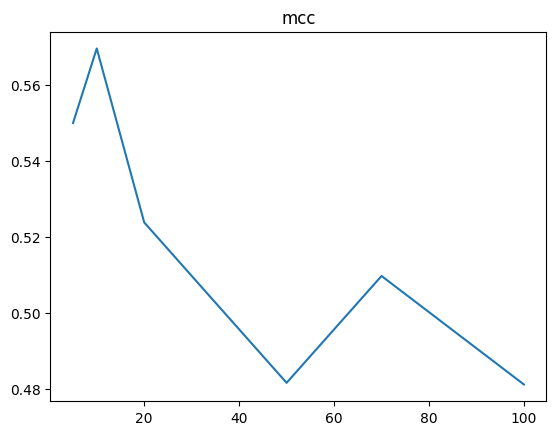

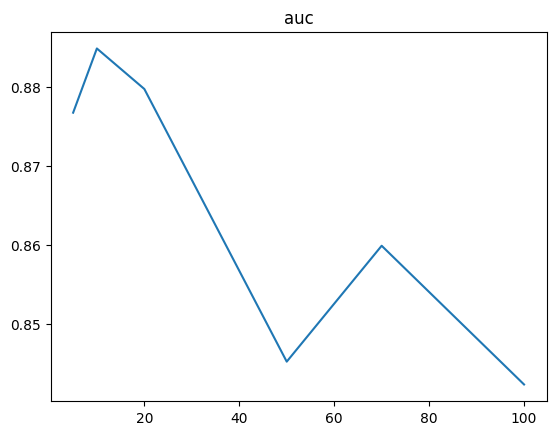

In [19]:
res = df.iloc[:,1:-2].groupby("Paraphrase %").mean().reset_index()
for metric in df.columns[3:-4]:
    plt.plot(res["Paraphrase %"], res[metric])
    plt.title(metric)
    plt.show()

In [20]:
# for k,v in models.items():
#     filehandler = open(fr'fitted_models/{k}.obj',"wb")
#     pickle.dump(v,filehandler)
#     filehandler.close()

In [21]:
# import shutil

# shutil.make_archive(f"zipped_models_{skip}", 'zip', "/kaggle/working/fitted_models")
